# Install required packages and set up environment if needed

In [1]:
import pandas as pd

from momentum_backtester.adapters.sp500_github_adapter import load_tiny_sample, load_sp500_data_wrds
from momentum_backtester.backtester import Backtester
from momentum_backtester.signals import price_momentum
from momentum_backtester.ranking import cross_sectional_rank
from momentum_backtester.aggregation import long_short_top_bottom_sector_neutral
from momentum_backtester.costs import turnover_costs
from momentum_backtester.analysis import Analysis

# Load the required data for backtesting

In [2]:
data = load_sp500_data_wrds(start_year=2020, end_year=2022)

Loading SP500 data...
Connecting to WRDS with username: zhenggong123
Loading library list...
Done
Connected to WRDS!
Loading SP500 data for year 2020...
the number of unique permnos for year 2020 is 504
the number of unique gvkeys for year 2020 is 499
Loading SP500 data for year 2021...
the number of unique permnos for year 2021 is 504
the number of unique gvkeys for year 2021 is 499
Loading SP500 data for year 2022...
the number of unique permnos for year 2022 is 503
the number of unique gvkeys for year 2022 is 498


In [7]:
# let's have a look at the data 
sp500_universes = data["sp500_universes"][0]
sp500_universes

SP500Universe(year=2020, gvkeys=<StringArray>
['012142', '012141', '012138', '001300', '001722', '012635', '012850',
 '003144', '013421', '003413',
 ...
 '178507', '179621', '179534', '179437', '010903', '180711', '180652',
 '004016', '183377', '184500']
Length: 499, dtype: string, permnos=<IntegerArray>
[10104, 10107, 10138, 10145, 10516, 10696, 10909, 11308, 11403, 11404,
 ...
 92602, 92611, 92614, 92655, 92778, 93002, 93089, 93096, 93132, 93429]
Length: 504, dtype: Int64)

In [9]:
# let's have a look at the data
# return df 
# we have two types of return_df:
# 1. retoto_df_wide: open-to-open return
# 2. retctc_df_wide: close-to-close return
retoto_df_wide = data["retoto_df_wide"]
retctc_df_wide = data["retctc_df_wide"]

# price df
# we have two types of price_df:
# 1. adjclose_df_wide: adjusted close price
# 2. adjopen_df_wide: adjusted open price
adjclose_df_wide = data["adjclose_df_wide"]
adjopen_df_wide = data["adjopen_df_wide"]

# sector df
sector_df_wide = data["sector_df_wide"]

# let's have a look at the data
# retoto_df_wide.tail()
# retctc_df_wide.tail()
# adjclose_df_wide.tail()
# adjopen_df_wide.tail()
sector_df_wide.tail()

permno,10104,10107,10138,10145,10516,10696,10909,11308,11403,11404,...,92614,92655,92778,93002,93089,93096,93132,93246,93429,93436
date,,,,,,,,,,,,,,,,,,,,,
2022-12-23,45,45,40,20,30,45,<NA>,30,45,55,...,55,35,<NA>,45,20,25,45,20,40,25
2022-12-27,45,45,40,20,30,45,<NA>,30,45,55,...,55,35,<NA>,45,20,25,45,20,40,25
2022-12-28,45,45,40,20,30,45,<NA>,30,45,55,...,55,35,<NA>,45,20,25,45,20,40,25
2022-12-29,45,45,40,20,30,45,<NA>,30,45,55,...,55,35,<NA>,45,20,25,45,20,40,25
2022-12-30,45,45,40,20,30,45,<NA>,30,45,55,...,55,35,<NA>,45,20,25,45,20,40,25


# Run the backtester

In [10]:
bt = Backtester(
    retoto_df_wide=retoto_df_wide,
    retctc_df_wide=retctc_df_wide,
    adjclose_df_wide=adjclose_df_wide,
    adjopen_df_wide=adjopen_df_wide,
    sector_df_wide=sector_df_wide,
    signal=lambda px: price_momentum(
        px, 
        lookback_months=11, 
        skip=1),
    ranker=cross_sectional_rank,
    aggregator=lambda ranks, sectors: long_short_top_bottom_sector_neutral(
        ranks, 
        sectors, 
        top_pctg=20, 
        bottom_pctg=20),
    costs=lambda w: turnover_costs(w, 10.0),
    rebal_freq="M",
)
results = bt.run()

In [23]:
# peek 
results.keys()
# results

dict_keys(['weights', 'signal', 'ranks', 'gross_returns', 'transaction_costs', 'net_returns', 'equity', 'retoto_df_wide'])

In [15]:
# quick summary
summary = {
    "start": results["net_returns"].index.min(),
    "end": results["net_returns"].index.max(),
    "n_days": int(results["net_returns"].shape[0]),
    "cum_return": float((1 + results["net_returns"]).prod() - 1.0),
}
summary

{'start': Timestamp('2020-01-02 00:00:00'),
 'end': Timestamp('2022-12-30 00:00:00'),
 'n_days': 756,
 'cum_return': -0.09485175420395109}

# Run analysis on the backtest results


In [ ]:
# load in analysis class
analysis = Analysis(output_dir="output")

In [ ]:
analysis.cagr(results["net_returns"], 252)

the CAGR is:  -0.0327


np.float64(-0.0327)

In [18]:
analysis.annual_vol(results["net_returns"], periods_per_year=252)

the annual volatility is:  0.1077


np.float64(0.1077)

In [20]:
analysis.sharpe(results["net_returns"], risk_free=0.0, periods_per_year=252)

the Sharpe ratio is:  -0.2544


np.float64(-0.2544)

In [21]:
analysis.max_drawdown(results["net_returns"])

the maximum drawdown is:  -0.1602


-0.1602

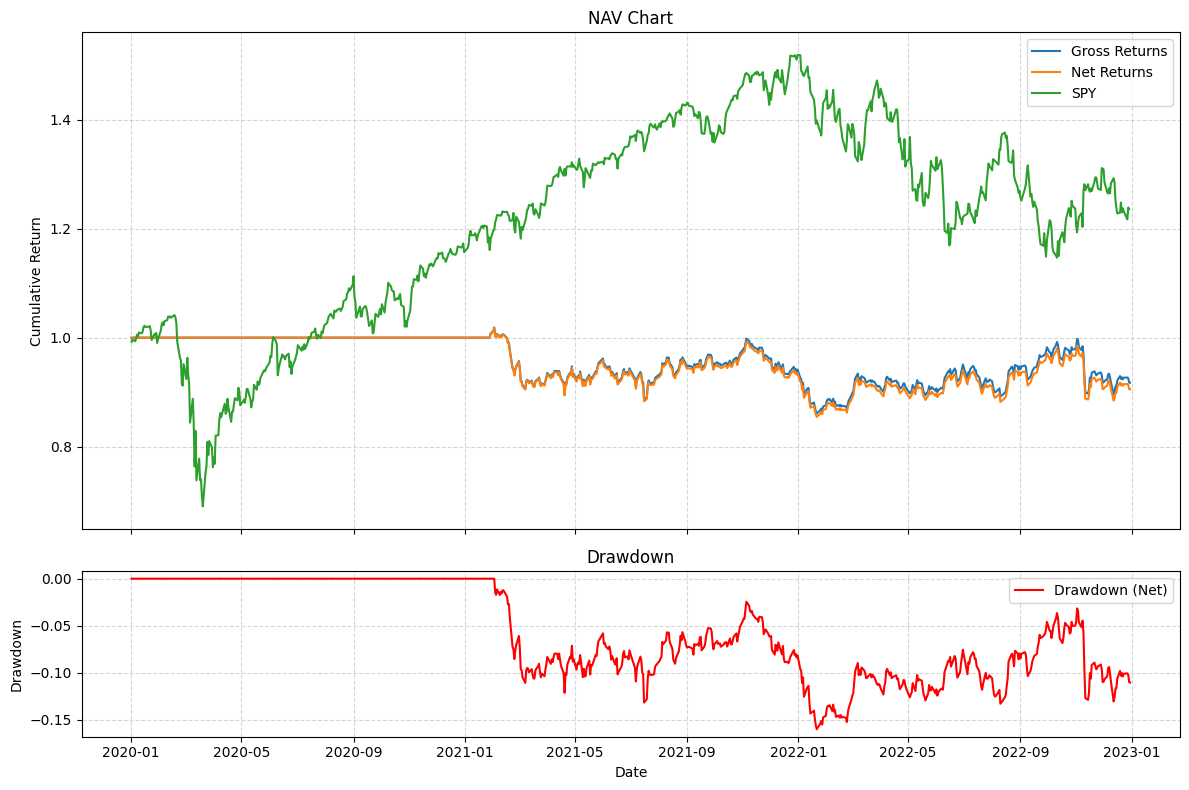

In [25]:
analysis.nav_chart(
    results["gross_returns"], 
    results["net_returns"], 
    incl_spy=True, 
    spy_daily=data["spy_daily"])

In [27]:
analysis.against_spy(results["net_returns"], data["spy_daily"], verbose=False)

{'alpha_annual': -0.0255,
 'beta': -0.018,
 'alpha_per_period': -0.0001,
 'r2': 0.0017}

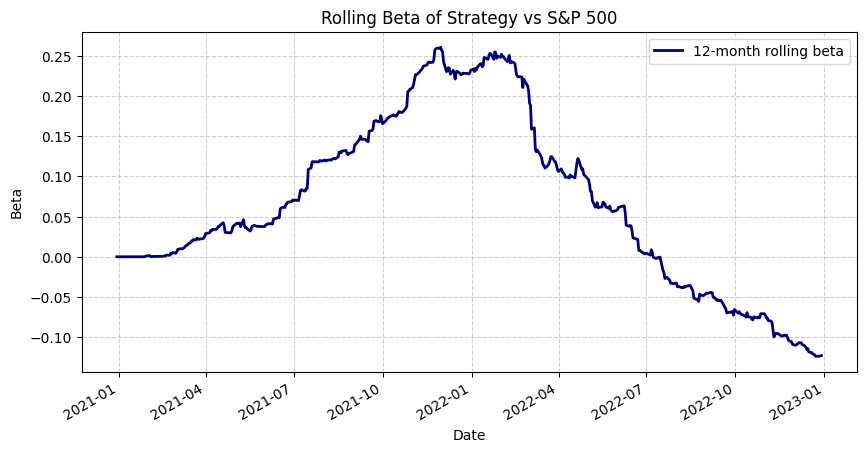

In [28]:
analysis.rolling_beta(results["net_returns"], data["spy_daily"])

In [ ]:
analysis.return_attr_sector(
    results["weights"], 
    data["sector_df_wide"], 
    results["retoto_df_wide"], 
    results["gross_returns"],
    verbose=False
    )


TypeError: Analysis.return_attr_sector() got an unexpected keyword argument 'verbose'

date
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-06    0.000000
2020-01-07    0.000000
2020-01-08    0.000000
                ...   
2022-12-23    0.000000
2022-12-27    0.000000
2022-12-28    0.000000
2022-12-29    0.000000
2022-12-30    0.876404
Length: 756, dtype: float64

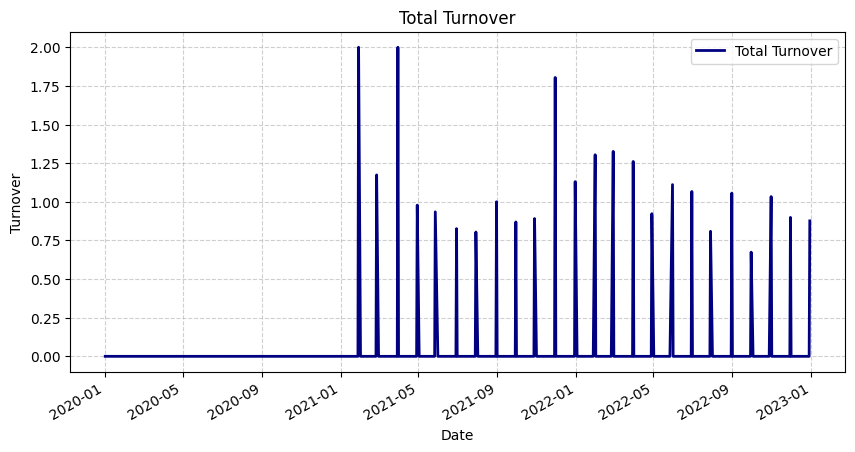

In [34]:
analysis.total_turnover(results["weights"], verbose=False)